### Introduction to ARCH modeling for financial time series

ARCH models are very popular for modeling the volatility of a time series. Specifically, ARCH means **A**uto**R**egressive **C**onditional **H**eteroskedasticity. This is in reference to the "innovations" around the mean of a time series. Volatility can really be thought of the change in "unexpected" deviations from your expecations (the mean). 

There is a popular library called [arch](https://arch.readthedocs.io/en/latest/univariate/introduction.html) in python which implements some of the most popular ARCH models that are used in the financial industry. Here, we will go through downloading some data, constructing returns, constructing a simple volatility model, and seeing what other things we get from the package. This will be useful for later reference when we need to do some sort of vol modeling. 

In [7]:
import yfinance as yf 
import pandas as pd 
import matplotlib.pyplot as plt
import numpy as np 

from arch import arch_model
from arch.univariate import StudentsT, Normal

In [2]:
ticker = "TLT"
data = yf.download(ticker, progress = False)

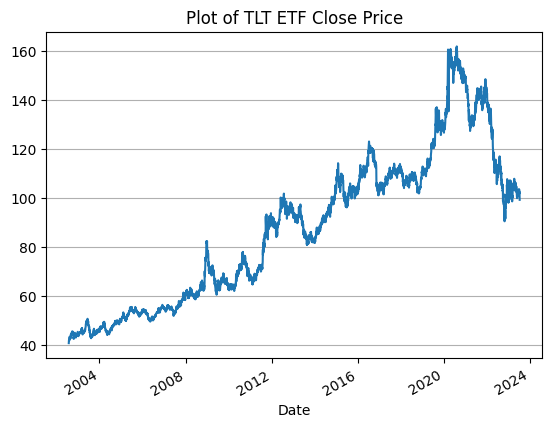

In [6]:
data['Adj Close'].plot()
plt.title("Plot of TLT ETF Close Price")
plt.grid(axis = 'y')
plt.show()

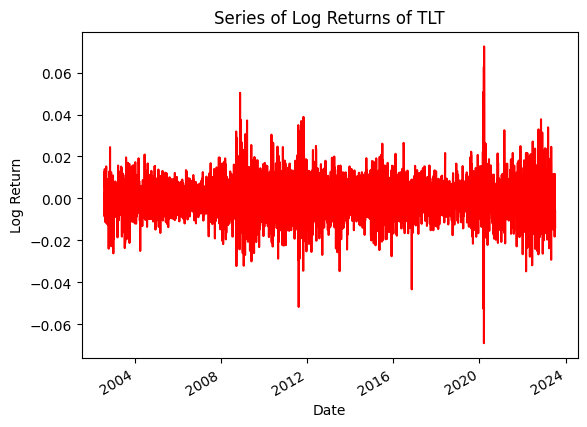

In [10]:
log_close = data['Adj Close'].apply(np.log)
log_returns = log_close.diff().dropna()
log_returns.plot(color = 'red')
plt.title("Series of Log Returns of TLT")
plt.ylabel("Log Return")
plt.show()

Some high level things to note: 
* The price series for TLT does seem to have a sense of trend
* The returns do not have a trend of going up or down and can be thought of as stationary at points
    * There are periods of large deviations in the returns and periods of low deviations
    * This is the "heteroskedastic" part of the equation. Large moves tend to follow large moves. Small moves tend to follow small moves. 
* We want to have a mdoel that will take into account this in our data. 

#### A very simple model

The simplest GARCH (1, 1) model can be specified where we assume that the every return is some random disturbance with a conditional normal distribution. This can be said as follows: 
\begin{aligned}
 r_t &= \mu_t + \epsilon_t \\
 \epsilon_t &= \sigma_t * e_t \\ 
 \sigma_t^2 &= \omega + \alpha\epsilon_{t-1}^2 + \beta\sigma_{t-1}^2
\end{aligned}

Here we will say that $\mu_t$ = 0. This could be very well be a fitted AR model or something else. More on that in a later section of this notebook. What we need to pay attention to are the $\sigma_t$, $e_t$, $\alpha$, $\beta$, and $\omega$. The $\sigma_t$ is basically our conditional volatility and you can see that it's a combination of the last period's estimate of conditional volatility and the past residual squared. The $\alpha$ and $\beta$ are values we need to fit and have a special relationship. Let's go ahead and fit one. 

In [34]:
from arch.univariate import ZeroMean, ConstantMean, GARCH, Normal, StudentsT

# Have to scale these values by 100 in order to get the optimizer to converge how we would like
scaling_factor = 100 
am = ZeroMean(y = log_returns * scaling_factor)
am.volatility = GARCH(1, 0, 1)
am.distribution = Normal()

In [35]:
type(am)

arch.univariate.mean.ZeroMean

We have create a ZeroMean model which has a GARCH(1, 0, 1) volatility and a normal distribution. We then go ahead and fit this model. 

In [36]:
results = am.fit(disp='off')

In [37]:
results

                       Zero Mean - GARCH Model Results                        
Dep. Variable:              Adj Close   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -6424.56
Distribution:                  Normal   AIC:                           12855.1
Method:            Maximum Likelihood   BIC:                           12874.8
                                        No. Observations:                 5270
Date:                Sun, Jul 09 2023   Df Residuals:                     5270
Time:                        20:44:49   Df Model:                            0
                              Volatility Model                              
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
omega      6.1062e-03  2.162e-03      2.825  4.731e-03 [1.

We just fit our first GARCH volatiilty model. Let's unpack these results. 
* It seems that all the parameters are significant based on traditional statistical testing. 
    * We can see that from the t-values and the corresponding p-values being below 0.05 (traditional critical value)

Let's see what the estimate of conditional volatility is. 

In [38]:
type(results)

arch.univariate.base.ARCHModelResult

In [40]:
fitted_vol = results.conditional_volatility / scaling_factor

ANNUALIZATION_FACTOR = 252
MONTHLY_FACTOR = 21

annualized_fitted_vol = fitted_vol * (ANNUALIZATION_FACTOR ** 0.5)
monthly_fitted_vol = fitted_vol * (MONTHLY_FACTOR ** 0.5)

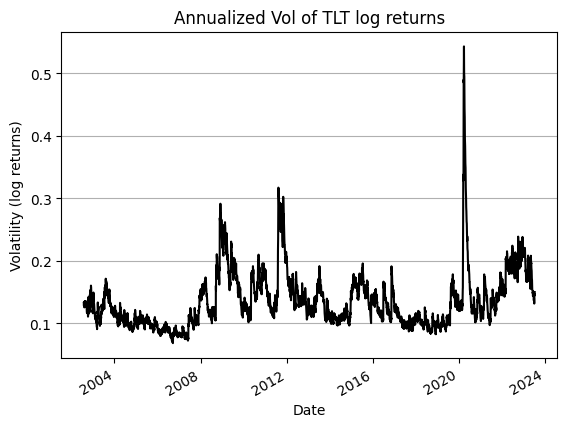

In [44]:
annualized_fitted_vol.plot(color = 'black')
plt.title("Annualized Vol of TLT log returns")
plt.ylabel("Volatility (log returns)")
plt.grid(axis = 'y')
plt.show()

We can see that the volatility estimate moves around a lot which makes sense. ARCH models are designed to be more response to large moves in the price and take some time to calm down after large events. We can see this in the 2020 spike in this data. Look how it goes up so much and then comes back down. We see similar dynamics in other volatility series and even in implied vol series. 


In [47]:
forecast = results.forecast(horizon=5, method='simulation', reindex=True)

In [51]:
pd.DataFrame(forecast.simulations.residual_variances) 

ValueError: Must pass 2-d input. shape=(5270, 1000, 5)